In [1]:
import re
import os
from bs4 import BeautifulSoup
import pandas as pd
import csv
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import random
from collections import Counter

### get all filename in rcv1

In [2]:
rootdir ='C:\\Users\\li\\dissertation\\rcv1\\'
filename = []
def listdir(path, list_name):
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        if os.path.isdir(file_path):
            listdir(file_path, list_name)
        elif os.path.splitext(file_path)[1]=='.xml':
            list_name.append(file_path)
listdir(rootdir,filename)

### read files / extract information

In [3]:
def find(data,whole):
    temp = []
    info = soup.contents[1]
    time_pattern = re.compile("newsitem\sdate=\"(.*?)\"")
    date = time_pattern.findall(str(info))
    item_pattern = re.compile("itemid=\"(.*?)\"")
    itemid = item_pattern.findall(str(info))
    
    code_pattern = re.compile("code=\"(.*?)\"\>")
    codes_ = soup.find_all("code")
    codes = code_pattern.findall(str(codes_))
    
    pattern = re.compile("\>(.*?)\<")
    title_ = soup.find_all("title")
    title = pattern.findall(str(title_))
    headline_ = soup.find_all("headline")
    headline = pattern.findall(str(headline_))
    byline_ = soup.find_all("byline")
    byline = pattern.findall(str(byline_))
    dateline_ = soup.find_all("dateline")
    dateline = pattern.findall(str(dateline_))
    text_ = soup.find_all("text")
    text = pattern.findall(str(text_))
    text_merge = ''
    for item in text:
        text_merge += item
    temp.append(date[0])
    temp.append(itemid[0])
    temp.append(codes)
    temp.append(title[0])
    temp.append(headline[0])
    temp.append(byline)
    temp.append(dateline)
    temp.append(text)
    whole.append(temp)

In [4]:
%%time
whole = []
for file in filename:
    data = open(file, encoding="iso-8859-1").read()
    soup = BeautifulSoup(data,'lxml')
    find(data, whole)

Wall time: 3min 1s


In [5]:
output = []
for item in whole:
    temp = []
    temp.append(item[1])
    temp.append(item[2])
    temp.append(item[3])
    temp.append(item[7])
    output.append(temp)
    print(temp)
    break

['2286', ['MEX', 'E11', 'ECAT', 'M11', 'M12', 'MCAT'], 'MEXICO: Recovery excitement brings Mexican markets to life.', ["Emerging evidence that Mexico's economy was back on the recovery track sent Mexican markets into a buzz of excitement Tuesday, with stocks closing at record highs and interest rates at 19-month lows.", '"Mexico has been trying to stage a recovery since the beginning of this year and it\'s always been getting ahead of itself in terms of fundamentals," said Matthew Hickman of Lehman Brothers in New York.', '"Now we\'re at the point where the fundamentals are with us. The history is now falling out of view."', 'That history is one etched into the minds of all investors in Mexico: an economy in crisis since December 1994, a free-falling peso and stubbornly high interest rates.', 'This week, however, second-quarter gross domestic product was reported up 7.2 percent, much stronger than most analysts had expected. Interest rates on governent Treasury bills, or Cetes, in the 

In [292]:
df = pd.DataFrame(output)
df.rename(columns={0:'itemid',1:'codes',2:'title',3:'text'},inplace=True)
df.to_csv("id_label_text_small.csv", index = False)

### data clean

In [5]:
stop = stopwords.words('english') #+ list(string.punctuation)
stemmer = nltk.PorterStemmer()

def text_clean(text):
    #tokenisation
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    # stemming
    for i in range(len(tokens)):
        tokens[i] = stemmer.stem(tokens[i])
    # remove stop words
    test_remove_ = [i for i in tokens if i not in stop]
    return test_remove_

def code_clean(code):
    temp = code.replace("[", "").replace("]","").replace("\'", "").replace(" ", "")
    return temp.split(",")

In [6]:
# build dictionary as container
info = {}
for news in whole:
    temp = {}
    temp['date'] = news[0]
    temp['itemid'] = news[1]
    temp['codes'] = news[2]
    temp['title'] = news[3]
    temp['headline'] = news[4]
    temp['byline'] = news[5]
    temp['dateline'] = news[6]
    temp['text'] = news[7]
    info[news[1]] = temp

In [8]:
# clean text and codes
for itemid, content in info.items():
    content['text'] = text_clean(str(content['text']))
    content['codes'] = code_clean(str(content['codes']))

### data exploration

1. text length

In [54]:
length_each_news = []
for itemid, content in info.items():
    length_each_news.append(int(len(content['text']) / 10))
sorted_length_each_news = sorted(length_each_news)

In [57]:
len_rank = Counter(length_each_news)
len_rank = sorted(len_rank.items(), key=lambda d: d[0], reverse = False)
len_freq = [pair[1] for pair in len_rank]

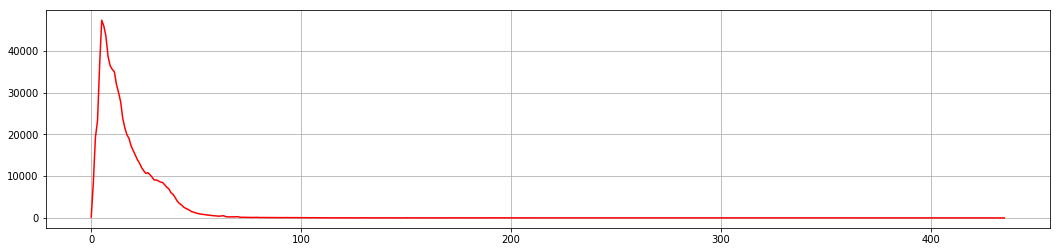

In [59]:
# x-axis: (words count / 10) after stemming
# y-axis: amount of news with this lence
plt.figure(figsize=(18,4))
plt.plot(range(0, len(len_freq)), len_freq, 'r-')
plt.grid()
plt.show()

most news: 0 - 500 words

around 40% news: 0 - 100 words

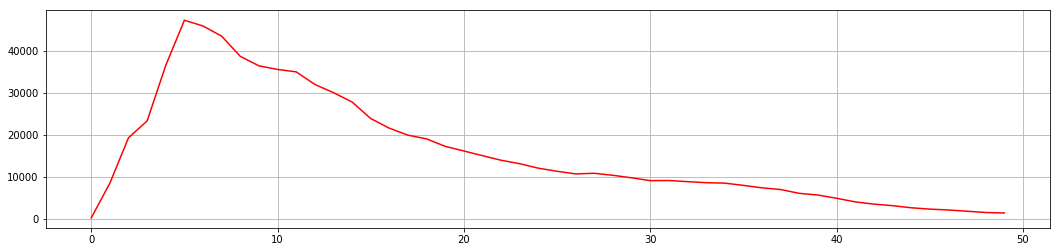

In [64]:
# Most news only has less than 500 words, over 40000 news has around 50 words (after stemming)
plt.figure(figsize=(18,4))
plt.plot(range(0, 50), len_freq[:50], 'r-')
plt.grid()
plt.show()

2. amount of codes for each news

most news: 0 - 10 labels

In [29]:
codes_each_news = []
for itemid, content in info.items():
    codes_each_news.append(len(content['codes']))
sorted_codes_each_news = sorted(codes_each_news)

In [44]:
cat = Counter(codes_each_news)
cat = sorted(cat.items(), key=lambda d: d[0], reverse = False)
cat_freq = [pair[1] for pair in cat]

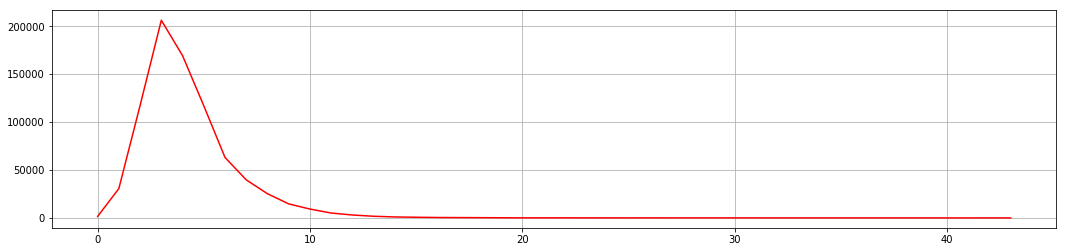

In [45]:
# most news only has less than 10 labels
plt.figure(figsize=(18,4))
plt.plot(range(0, len(cat)), cat_freq, 'r-')
plt.grid()
plt.show()

3. code frequency(how many times has a label appeared)

In [78]:
all_codes = []
for itemid, content in info.items():
    for item in content['codes']:
        all_codes.append(item)

In [79]:
random.seed(666)
unique_codes = set(all_codes)
labels = list(unique_codes)

In [80]:
from collections import Counter
counter = Counter(all_codes)
rank_freq = sorted(counter.items(), key=lambda d: d[1], reverse = False)

In [16]:
len(rank_freq)

752

In [1]:
# rank_freq

In [22]:
freq = []
code_info = []
for pair in rank_freq:
    code_info.append(pair[0])
    freq.append(pair[1])

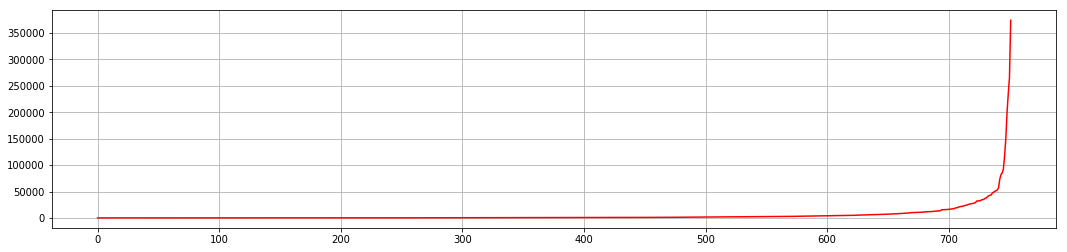

In [25]:
# plot all frequencies
plt.figure(figsize=(18,4))
plt.plot(range(0, len(freq)), freq, 'r-')
plt.grid()
plt.show()

0 - 80 labels: appear 0 - 20 times in the whole dataset

250 labels: less than 200 times

250 labels: 200 - 1600 times

10 labels: over 50000 times

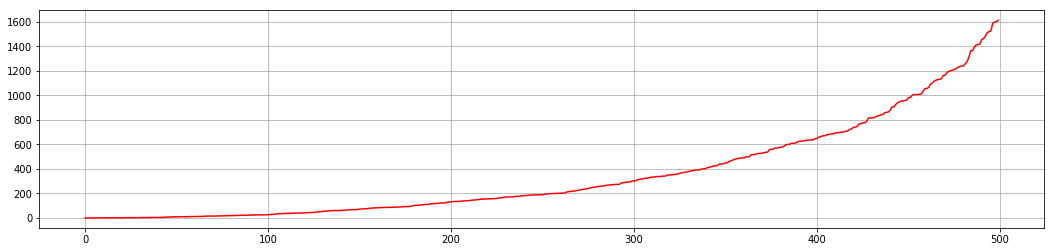

In [66]:
# near 450 labels only appear less than 1000 times
plt.figure(figsize=(18,4))
plt.plot(range(0, 500), freq[:500], 'r-')
plt.grid()
plt.show()

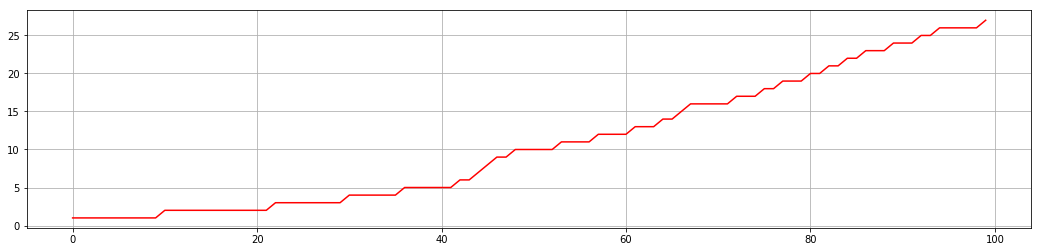

In [67]:
# 80 labels only appear less than 20 times
plt.figure(figsize=(18,4))
plt.plot(range(0, 100), freq[:100], 'r-')
plt.grid()
plt.show()

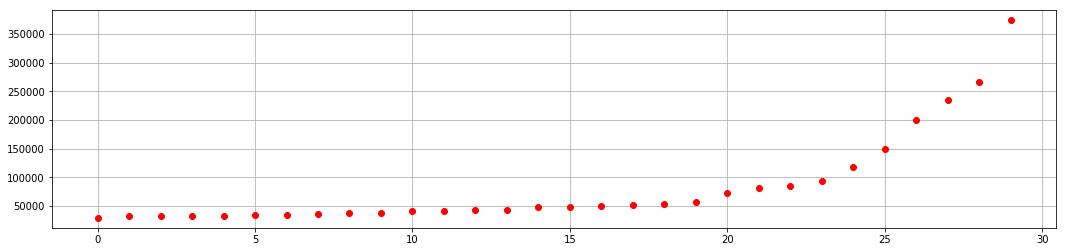

In [28]:
# around 10 labels appear over 50000 times
plt.figure(figsize=(18,4))
plt.plot(range(0, 30), freq[-30:], 'ro')
plt.grid()
plt.show()

4. hierachical labels

Topic: CCAT, ECAT, GCAT, MCAT (cat label will apppear without its subclass)
    
    e.g. CCAT -- C15 -- C151 & C152
    
Industry: it has hierachical structure, but it has little effect on the classification

Region: no hierachical structure